# BTC-USD @24h

In [2]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
SP500_FILENAME = './data_clean/sp500.csv'
NEWS_DATA_FILENAME = './data_clean/abcnews-date-text.with-sentiment.csv'
OUT_FILENAME = './results/btc24h_ohlcw_sp500_sentiment.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [3]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [5]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


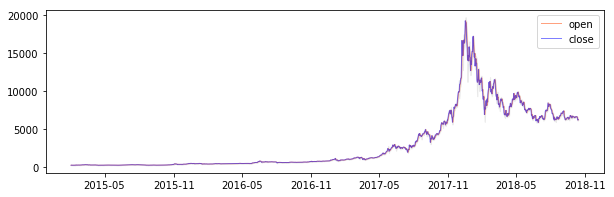

In [6]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [7]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


> size: 933


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-02,2020.85,1996.67,2021.66,1980.90,NaN,0
2015-02-03,2050.03,2022.71,2050.30,2022.71,NaN,0
2015-02-04,2041.51,2048.86,2054.74,2036.72,NaN,0
2015-02-05,2062.52,2043.45,2063.55,2043.45,NaN,0
2015-02-06,2055.47,2062.28,2072.40,2049.97,NaN,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-08,2884.43,2877.53,2889.45,2862.08,NaN,0
2018-10-09,2880.34,2882.51,2894.83,2874.27,NaN,0
2018-10-10,2785.68,2873.90,2874.02,2784.86,NaN,0
2018-10-11,2728.37,2776.87,2795.14,2710.51,NaN,0
2018-10-12,2767.13,2770.54,2775.77,2729.44,NaN,0


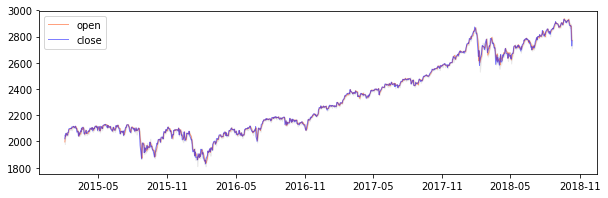

In [8]:
data_sp500 = pd.read_csv(
    SP500_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data_sp500))
dd(data_sp500.dtypes)
dd(data_sp500.head())
dd(data_sp500.tail())
simple_plot(data_sp500, show_xlabels=False)

In [9]:
data = etl.augment(data24h, data_sp500, 7, '_sp500')
data.head(10)

,close,open,high,low,volume,missing,weekday,close_sp500,slope_sp500,r2_sp500
datetime,,,,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6,NaN,0.000000e+00,0.000000
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0,2020.85,0.000000e+00,0.000000
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1,2050.03,0.000000e+00,0.000000
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2,2041.51,0.000000e+00,0.000000
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3,2062.52,0.000000e+00,0.000000
2015-02-06,222.9,216.8,225.9,214.9,4.73,0,4,2055.47,0.000000e+00,0.000000
2015-02-07,228.6,223.4,231.1,221.8,6.36,0,5,NaN,0.000000e+00,0.000000
2015-02-08,224.2,228.3,232.9,219.7,5.46,0,6,NaN,9.459491e-14,0.647589
2015-02-09,220.7,224.2,226.0,215.0,19.48,0,0,2046.74,9.459491e-14,0.647589


> size: 79


headline_text     object
sentiment        float64
dtype: object

,headline_text,sentiment
datetime,,
2011-05-14,race call btc cup doomben,0.3
2012-05-09,bufferings hopes slump after btc cup draw,0.0
2013-04-17,kohler value bitcoin gold,0.3
2013-05-11,cummings colt on song in btc cup,0.3
2013-10-26,us seizes bitcoins from man linked to silk road,-0.3


,headline_text,sentiment
datetime,,
2017-12-15,coinbase is going to add altcoins to its platf...,-0.4
2017-12-15,us prosecutors rush to sell bitcoin seized in ...,-0.4
2017-12-19,rob pyne turns to bitcoin for post political c...,0.0
2017-12-20,north korean hackers raiding bitcoin exchanges,-0.1
2017-12-23,bitcoin plunges in value after manic upward swing,0.2


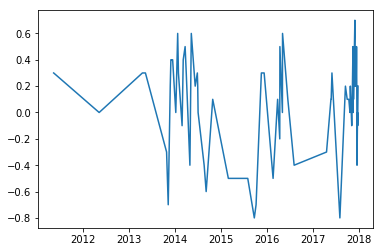

In [10]:
data_news = pd.read_csv(
    NEWS_DATA_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data_news))
dd(data_news.dtypes)
dd(data_news.head())
dd(data_news.tail())
plt.figure(facecolor='white')
plt.plot(data_news.index.values, data_news['sentiment'])

In [12]:
data_news[data_news.index >= '2015-02-01'].shape

(50, 2)

In [10]:
data = etl.augment_with_news_sentiment(data, data_news, 30, '_last30d')

In [12]:
data[data.index <= '2015-10-01'].tail(30)

,close,open,high,low,volume,missing,weekday,close_sp500,slope_sp500,r2_sp500,sentiment,sentiment_last30d
datetime,,,,,,,,,,,,
2015-09-02,228.8,227.6,230.8,226.0,21.57,0,2,1948.86,-6.011436e-14,0.169922,NaN,0.0
2015-09-03,226.8,228.8,230.0,226.5,19.71,0,3,1951.13,-1.107933e-13,0.617845,NaN,0.0
2015-09-04,231.1,226.8,231.4,226.3,20.89,0,4,1921.22,-9.094602e-14,0.410552,NaN,0.0
2015-09-05,235.4,231.1,237.2,229.2,20.03,0,5,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-06,240.4,235.4,244.2,235.0,25.52,0,6,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-07,240.1,240.4,242.9,238.4,23.16,0,0,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-08,244.0,240.1,246.2,239.9,23.71,0,1,1969.41,2.821759e-14,0.027432,NaN,0.0
2015-09-09,238.0,244.0,244.2,237.0,23.26,0,2,1942.04,4.525602e-14,0.267580,NaN,0.0
2015-09-10,238.5,238.0,241.6,234.8,20.54,0,3,1952.29,3.076478e-14,0.152566,NaN,0.0


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs. More consistency at 10 but average quality drops.

data ~ (600, 9)
--- 0.014s to model compilation time


--- Created model id: 139774982100240
Tensor("lstm_1_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              476       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 904
Trainable params: 904
Non-trainable params: 0
____________________________________________________________

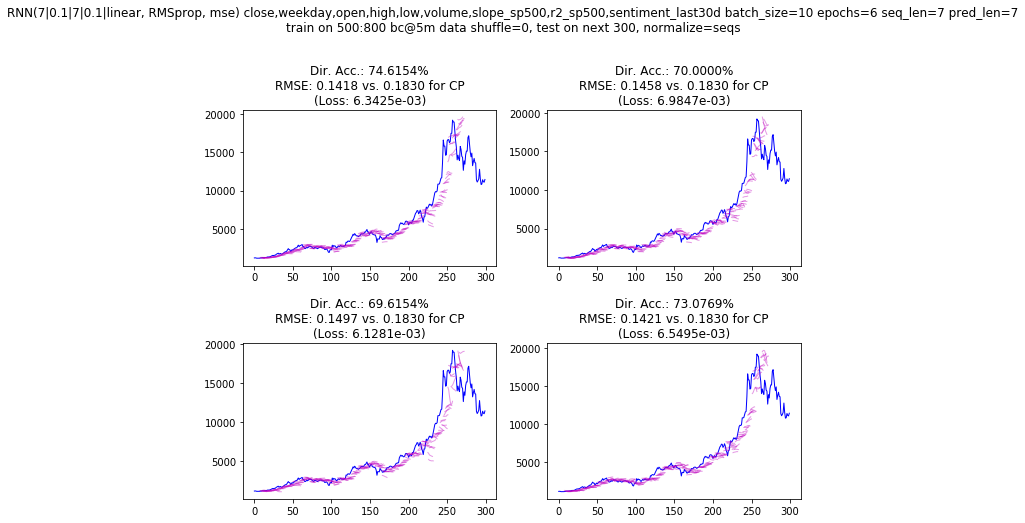

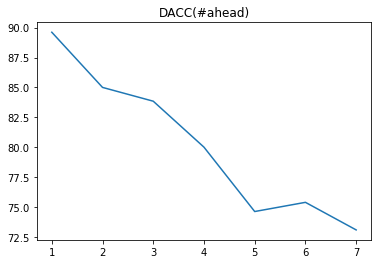

--- 19.884s to run experiment



In [14]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.014s to model compilation time


--- Created model id: 139773277778512
Tensor("lstm_25_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 7)              476       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 904
Non-trainable params: 0
___________________________________________________________

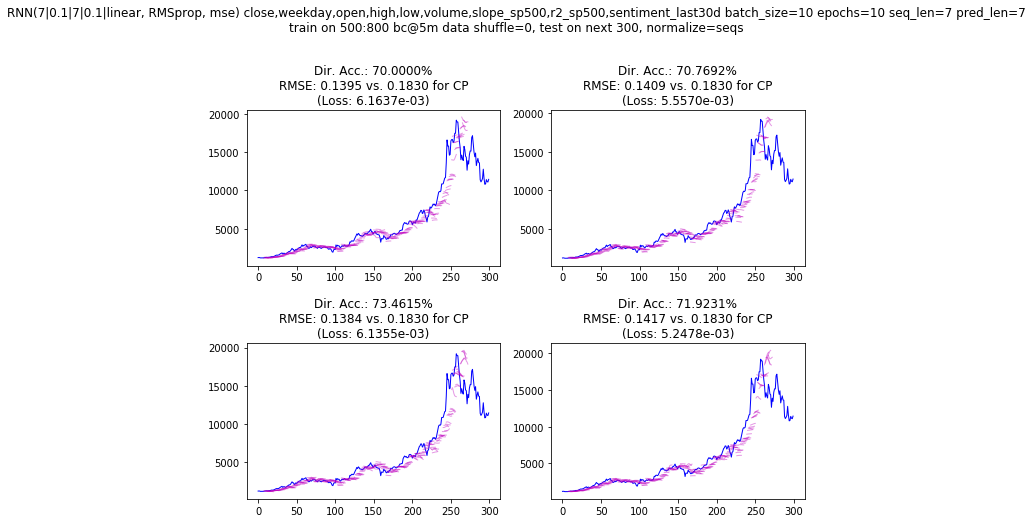

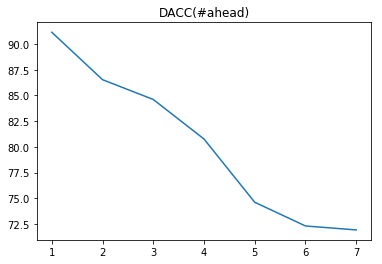

--- 32.669s to run experiment



In [17]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (900, 9)
--- 0.016s to model compilation time


--- Created model id: 139773193117840
Tensor("lstm_33_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 7)              476       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 904
Non-trainable params: 0
___________________________________________________________

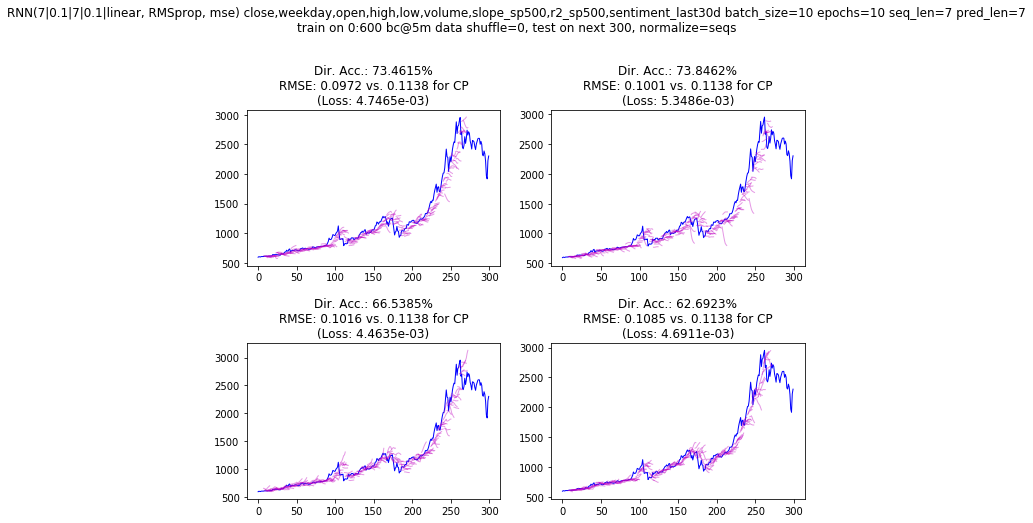

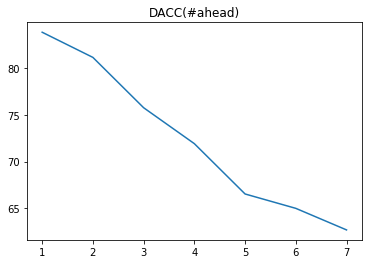

--- 44.091s to run experiment



In [18]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.

data ~ (600, 9)
--- 0.015s to model compilation time


--- Created model id: 139773126207568
Tensor("lstm_41_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 3)              156       
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_42 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4         
Total params: 244
Trainable params: 244
Non-trainable params: 0
___________________________________________________________

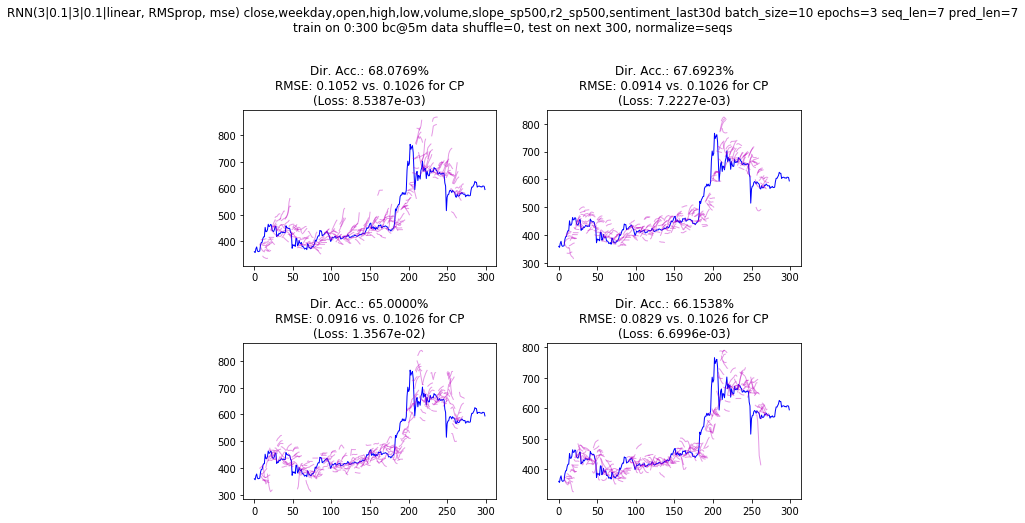

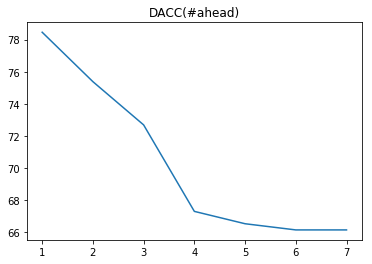

--- 35.541s to run experiment



In [19]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.016s to model compilation time


--- Created model id: 139773123359568
Tensor("lstm_57_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 3)              156       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_58 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 4         
Total params: 244
Trainable params: 244
Non-trainable params: 0
___________________________________________________________

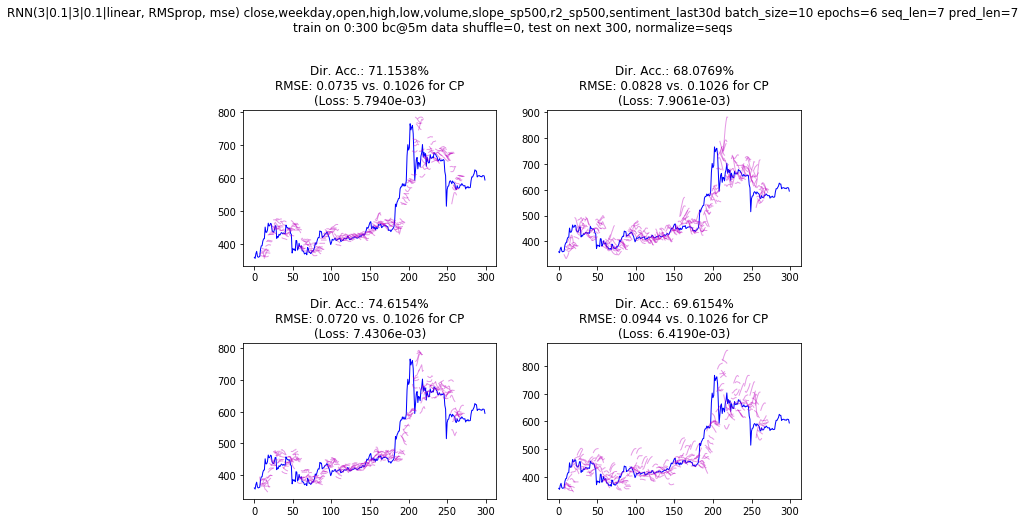

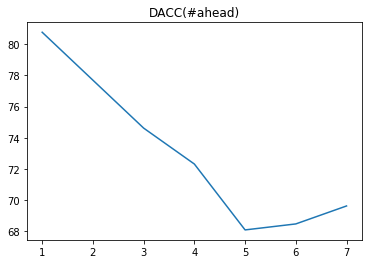

--- 46.639s to run experiment



In [21]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.016s to model compilation time


--- Created model id: 139772982825168
Tensor("lstm_65_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 3)              156       
_________________________________________________________________
dropout_65 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_66 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total params: 244
Trainable params: 244
Non-trainable params: 0
___________________________________________________________

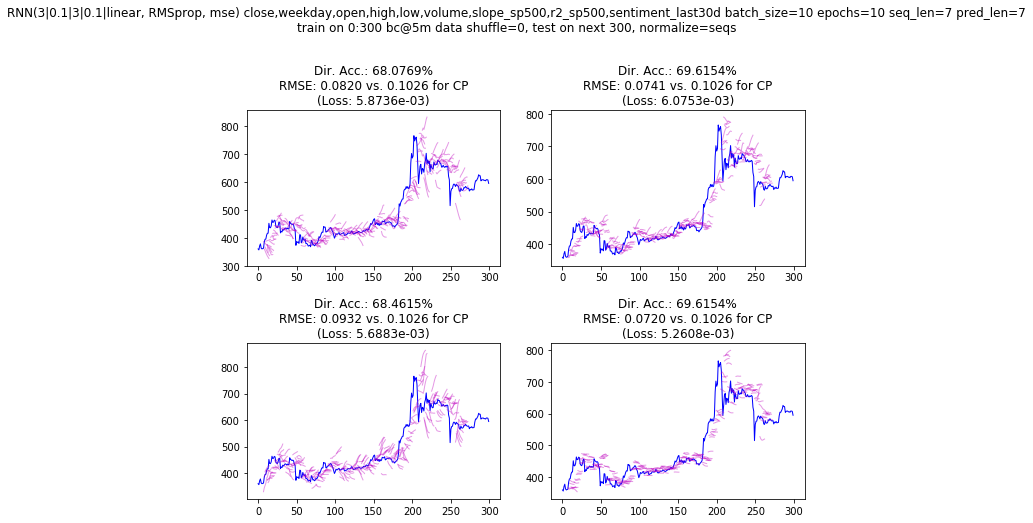

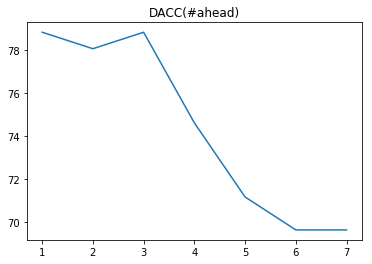

--- 51.467s to run experiment



In [22]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 14|0.1|14|0.1

**Conclusion:** Not better results than smaller networks?

data ~ (600, 9)
--- 0.019s to model compilation time


--- Created model id: 139772842773584
Tensor("lstm_73_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 7, 14)             1344      
_________________________________________________________________
dropout_73 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_74 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 15        
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_______________________________________________________

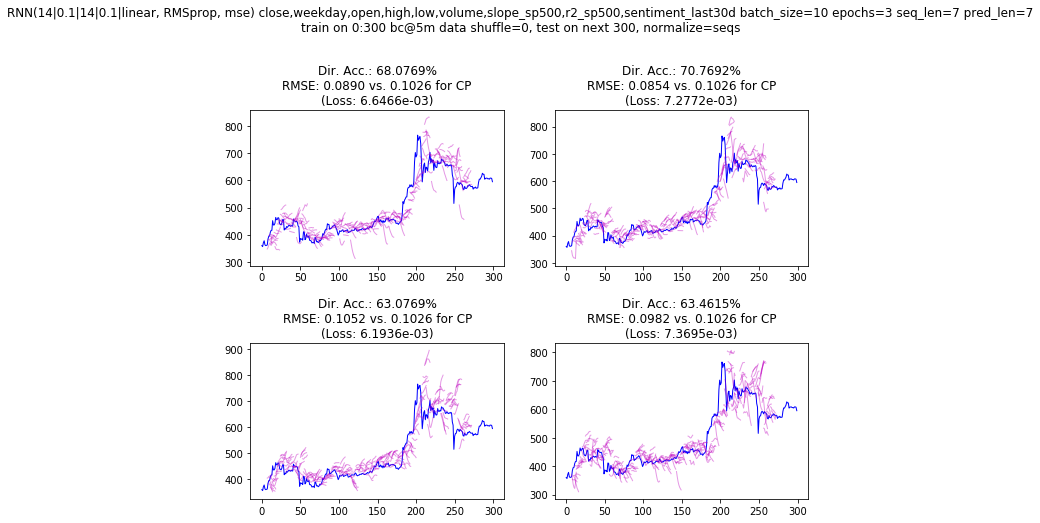

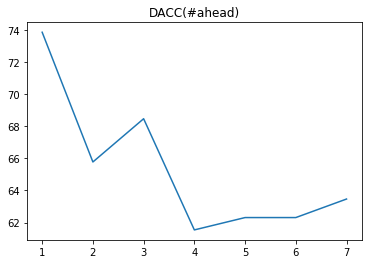

--- 53.413s to run experiment



In [24]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.018s to model compilation time


--- Created model id: 139772840763536
Tensor("lstm_81_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 7, 14)             1344      
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_82 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 15        
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_______________________________________________________

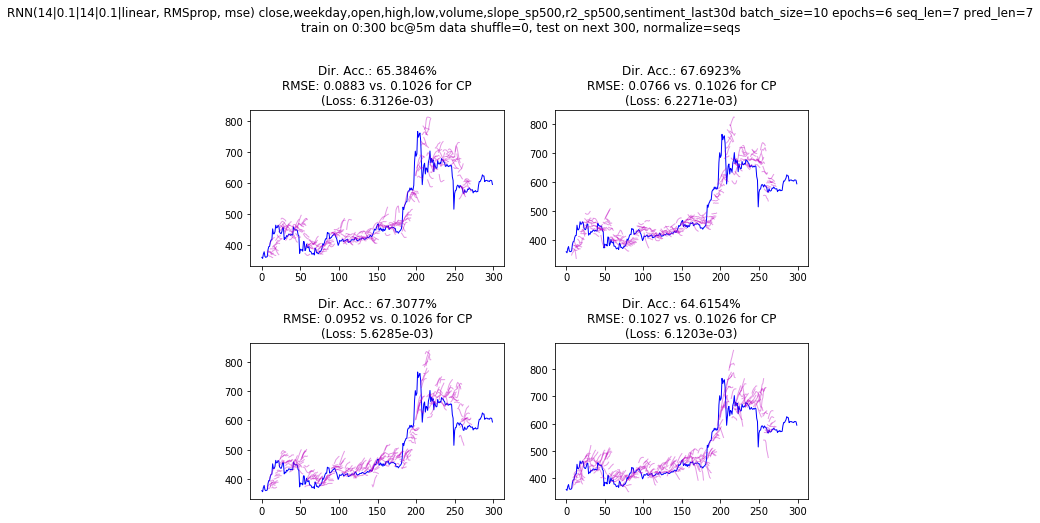

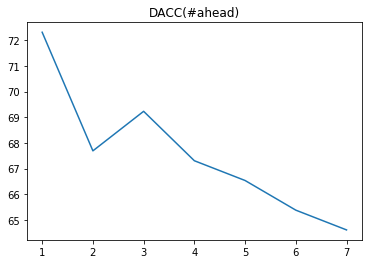

--- 57.803s to run experiment



In [25]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.018s to model compilation time


--- Created model id: 139775044799568
Tensor("lstm_89_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 7, 14)             1344      
_________________________________________________________________
dropout_89 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_90 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 15        
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_______________________________________________________

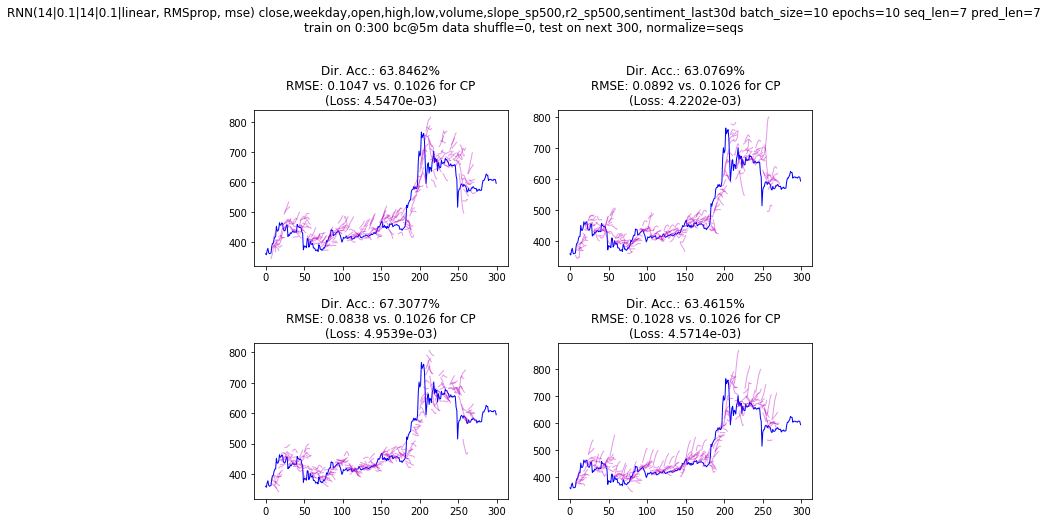

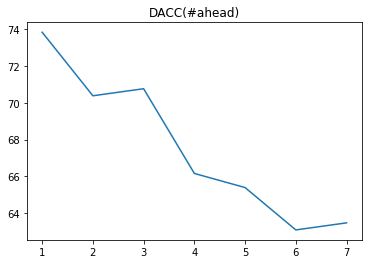

--- 67.132s to run experiment



In [26]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 9)
--- 0.017s to model compilation time


--- Created model id: 139772708603664
Tensor("lstm_97_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 7, 14)             1344      
_________________________________________________________________
dropout_97 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_98 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 15        
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_______________________________________________________

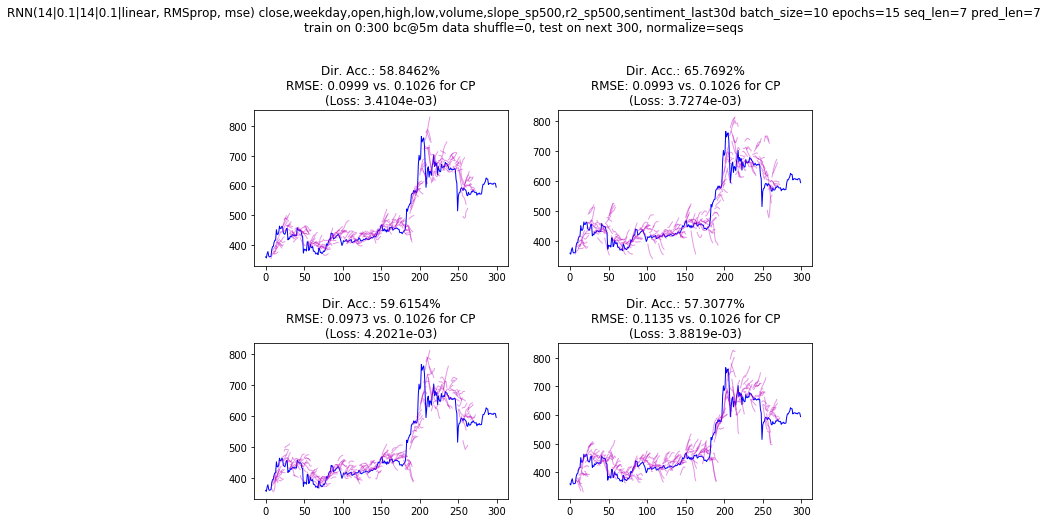

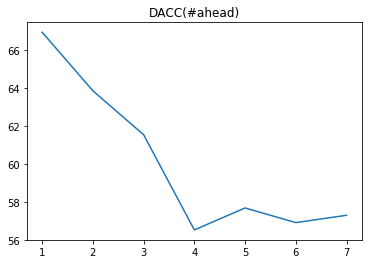

--- 73.219s to run experiment



In [27]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 30|0.1|30|0.1

**Conclusion:** Really bad results, best at 3-6 epochs but comparatively too bad to worth condiering this further.

data ~ (900, 9)
--- 0.017s to model compilation time


--- Created model id: 139772620937936
Tensor("lstm_105_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (None, 7, 30)             4800      
_________________________________________________________________
dropout_105 (Dropout)        (None, 7, 30)             0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dropout_106 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 31        
Total params: 12,151
Trainable params: 12,151
Non-trainable params: 0
____________________________________________________

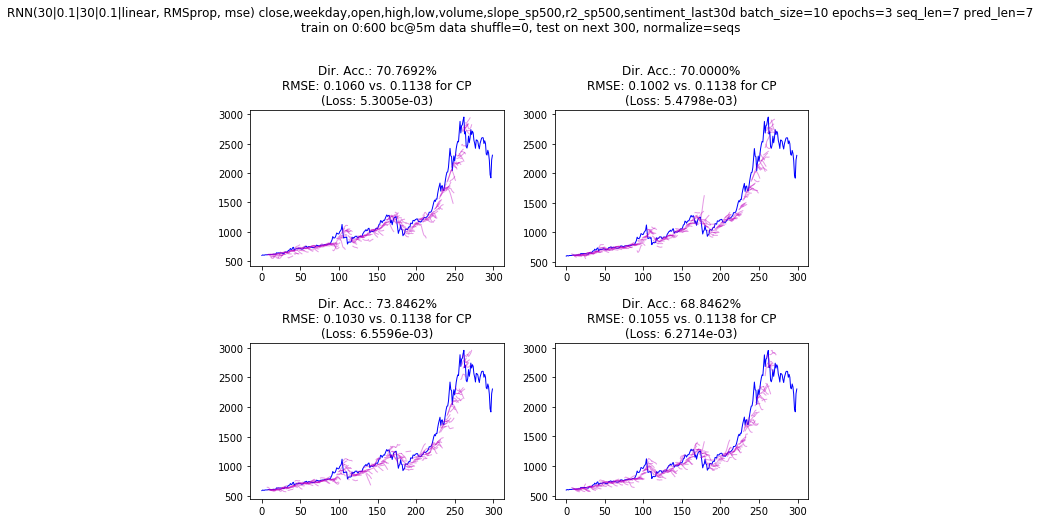

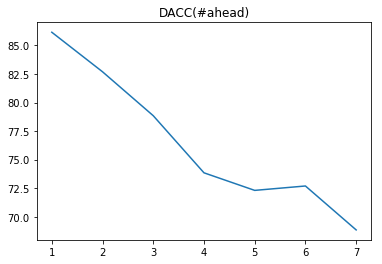

--- 72.003s to run experiment



In [28]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (900, 9)
--- 0.018s to model compilation time


--- Created model id: 139772568407824
Tensor("lstm_113_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 7, 30)             4800      
_________________________________________________________________
dropout_113 (Dropout)        (None, 7, 30)             0         
_________________________________________________________________
lstm_114 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dropout_114 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 31        
Total params: 12,151
Trainable params: 12,151
Non-trainable params: 0
____________________________________________________

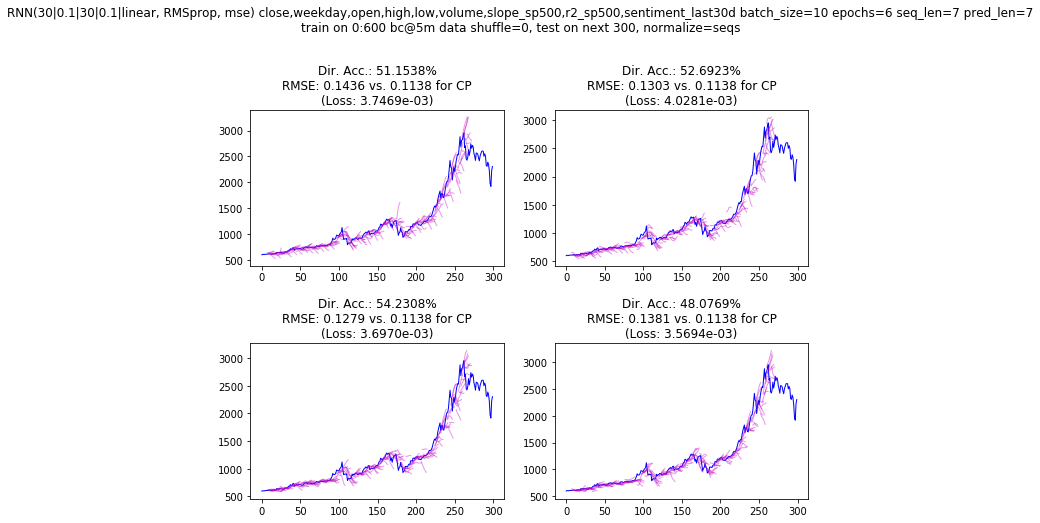

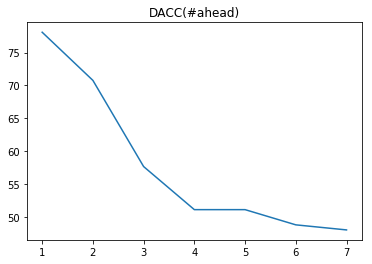

--- 82.357s to run experiment



In [29]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [38]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data,
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([7, 0.1, 7, 0.1]),
    # training:
    'epochs': 10,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [32]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [33]:
def full_run(idx_from, idx_to, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(OUT_FILENAME, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()

In [ ]:
DEFAULT_PARAMS['features'] = ['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d']
full_run(300, 1051, write_csv_header=True)


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 9)
--- 0.018s to model compilation time


--- Created model id: 139772480906448
Tensor("lstm_127_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 7, 7)              476       
_________________________________________________________________
dropout_127 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_128 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 904
Non-trainable params: 0
__

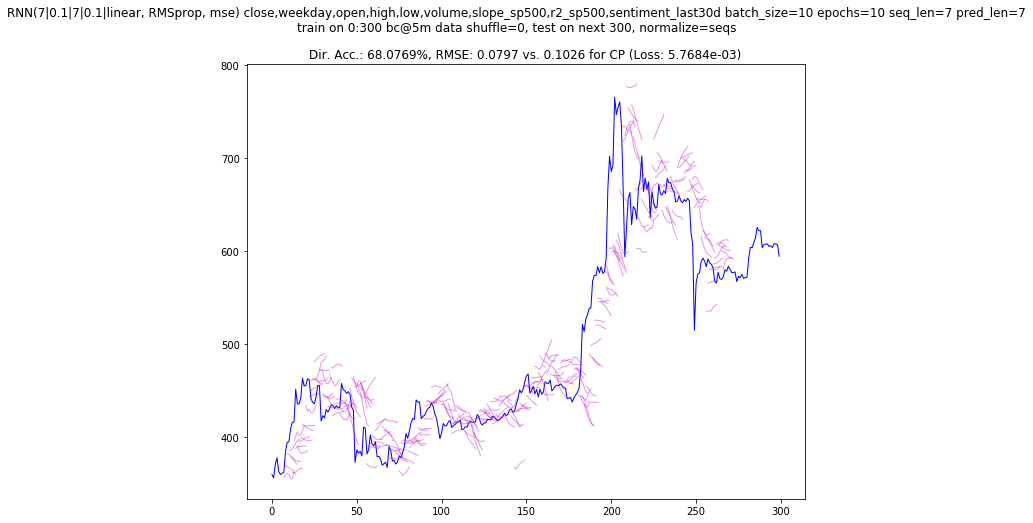

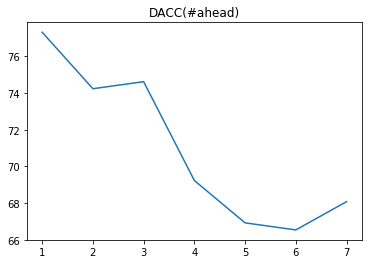

--- 20.981s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 9)
--- 0.017s to model compilation time


--- Created model id: 139772248613008
Tensor("lstm_129_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 7, 7)              476       
_________________________________________________________________
dropout_129 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_130 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_130 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 

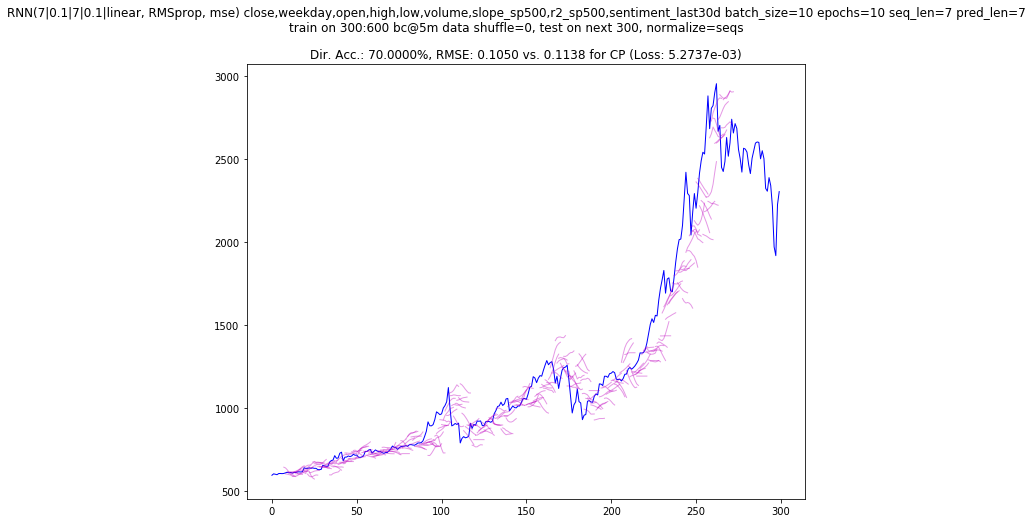

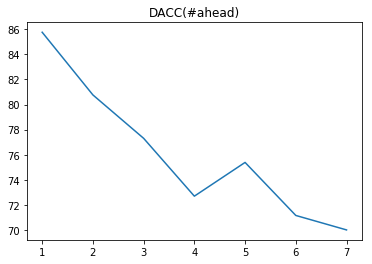

--- 20.940s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 9)
--- 0.017s to model compilation time


--- Created model id: 139772225537808
Tensor("lstm_131_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 7, 7)              476       
_________________________________________________________________
dropout_131 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_132 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 

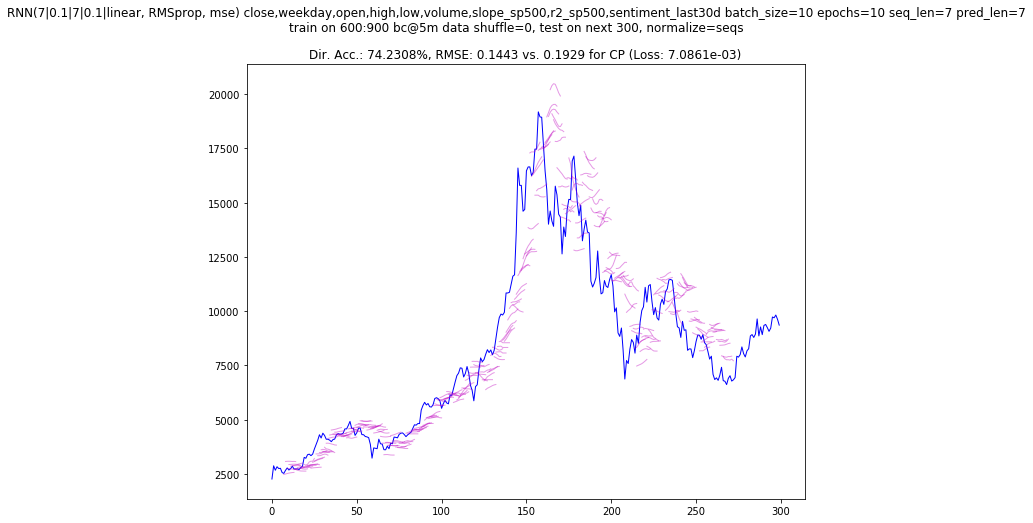

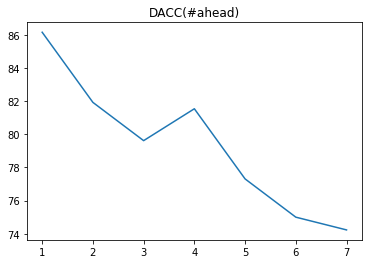

--- 21.410s to run segment

--- 63.332s to full run 300 - 1051



In [39]:
DEFAULT_PARAMS['features'] = ['close', 'weekday',
                  'open', 'high', 'low', 'volume',
                  'slope_sp500', 'r2_sp500',
                  'sentiment_last30d']
full_run(300, 1051, write_csv_header=False)

In [40]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",0,300,300,False,seqs,0.007783,0.0946%,0.1026%,63.0769%
1,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",300,600,300,False,seqs,0.006724,0.0936%,0.1138%,75.3846%
2,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",600,900,300,False,seqs,0.007835,0.1499%,0.1929%,76.9231%
3,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",0,300,300,False,seqs,0.005768,0.0797%,0.1026%,68.0769%
4,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",300,600,300,False,seqs,0.005274,0.1050%,0.1138%,70.0000%
5,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",600,900,300,False,seqs,0.007086,0.1443%,0.1929%,74.2308%


In [37]:
(63.07 + 75.38 + 76.92) / 3

71.79

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%


In [30]:
(70.00 + 79.61 + 77.30) / 3

75.63666666666667